In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CO-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn033491,MGMGEGGGGGGKCYPAGWGIAAKPCDLCKSAVALLFCRVDSAFLCM...,361,1
1,Achn062021,MGYLCDFCGEQRSMVYCRSDAACLCLSCDRNVHSANALSRRHSRTL...,407,1
2,Achn063291,MEPLCEFCSLARAMIYCKSDSARLCLRCDTCVHSANYLSRRHARSL...,433,1
3,Achn169891,MMSPKSRSGESVPCDFCNEKIAVVYCRADSAKLCLFCDHHVHSANP...,480,1
4,Achn176481,MVYMCDFCGEQRSIVYCRSDAASLCFSCDHSVHSANALSRRHFRTL...,412,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3955,0.005102,0.000000,0.000000,0.000000,0.000000,0.000000,0.005102,0.010204,0.005102,0.000000,...,0.000000,0.000000,0.0,0.0,0.005102,0.010204,0.000000,0.0,0.0,0.0
1131,0.007194,0.004796,0.007194,0.004796,0.002398,0.000000,0.002398,0.002398,0.009592,0.000000,...,0.002398,0.000000,0.0,0.0,0.002398,0.000000,0.004796,0.0,0.0,0.0
3645,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4162,0.024615,0.000000,0.000000,0.006154,0.003077,0.018462,0.000000,0.000000,0.003077,0.003077,...,0.000000,0.000000,0.0,0.0,0.003077,0.003077,0.000000,0.0,0.0,0.0
1262,0.023747,0.002639,0.007916,0.002639,0.002639,0.002639,0.000000,0.005277,0.005277,0.002639,...,0.000000,0.002639,0.0,0.0,0.002639,0.002639,0.000000,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3377, 441)
X_test: (845, 441)
y_train: (3377,)
y_test: (845,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step - accuracy: 0.4531 - loss: 0.6935

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5838 - loss: 0.6846   

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6276 - loss: 0.6721 - val_accuracy: 0.9630 - val_loss: 0.3354


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.3839

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9656 - loss: 0.2177

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9669 - loss: 0.2007 - val_accuracy: 0.9778 - val_loss: 0.0846


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0581

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0541

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0552 - val_accuracy: 0.9837 - val_loss: 0.0703


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0630

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0389

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0389 - val_accuracy: 0.9793 - val_loss: 0.0760


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0450

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0300

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0293 - val_accuracy: 0.9822 - val_loss: 0.0660


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0034

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0288

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0269 - val_accuracy: 0.9882 - val_loss: 0.0638


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0121

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0146

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0155 - val_accuracy: 0.9837 - val_loss: 0.0783


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0097

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.9852 - val_loss: 0.0722


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0109

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0114 - val_accuracy: 0.9852 - val_loss: 0.0659


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0043

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.9808 - val_loss: 0.0981


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0084

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0094 - val_accuracy: 0.9837 - val_loss: 0.0747


Epoch 12/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0363

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0142

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0129 - val_accuracy: 0.9867 - val_loss: 0.0745


Epoch 13/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.8135e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0030    

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9867 - val_loss: 0.0844


Epoch 14/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1611e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0038    

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9867 - val_loss: 0.0814


Epoch 15/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7617e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0010    

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9852 - val_loss: 0.0956


Epoch 16/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0504e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0019    

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9689 - val_loss: 0.1212



[Train Accuracy: 99.78% - Test Accuracy: 97.28%]


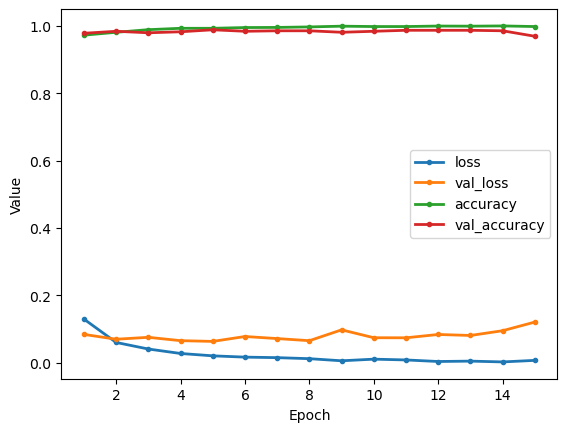

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3955,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131,0.000000,0.0,0.002404,0.002404,0.0,0.000000,0.0,0.000000,0.002404,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3645,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4162,0.003086,0.0,0.000000,0.000000,0.0,0.009259,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,0.007937,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.002646,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3377, 8673)
X_test: (845, 8673)
y_train: (3377,)
y_test: (845,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,220,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,809 (8.64 MB)

 Trainable params: 2,263,809 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - accuracy: 0.5156 - loss: 0.6932

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5385 - loss: 0.6926   

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5303 - loss: 0.6918

25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5245 - loss: 0.6902

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5263 - loss: 0.6869

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5430 - loss: 0.6803

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5504 - loss: 0.6771 - val_accuracy: 0.9778 - val_loss: 0.3916


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3681

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.3386 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.3050

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9939 - loss: 0.2684

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.2391

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.2184

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.2162 - val_accuracy: 0.9926 - val_loss: 0.0598


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0038

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0102 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0108

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0112

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0116

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0116 - val_accuracy: 0.9941 - val_loss: 0.0578


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0034

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0033 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0031

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0029

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0028

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9896 - val_loss: 0.0650


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.8648e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013     

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0015

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0016

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9926 - val_loss: 0.0635


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.2902e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4381e-04 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7664e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7624e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8009e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8012e-04 - val_accuracy: 0.9941 - val_loss: 0.0649


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1591e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0416e-04 

19/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6281e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9749e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4834e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0616e-04 - val_accuracy: 0.9896 - val_loss: 0.0718


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.2191e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4481e-04 

19/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1198e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1479e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0497e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9669e-04 - val_accuracy: 0.9926 - val_loss: 0.0679


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.1838e-05

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2442e-04 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3205e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5415e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6220e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6299e-04 - val_accuracy: 0.9896 - val_loss: 0.0774


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.0051e-05

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0648e-04 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3634e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4799e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4759e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4555e-04 - val_accuracy: 0.9941 - val_loss: 0.0689


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.4829e-05

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8522e-04 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3712e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0049e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7884e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6291e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5958e-04 - val_accuracy: 0.9911 - val_loss: 0.0754


Epoch 12/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.8697e-06

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6360e-05 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3492e-05

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4928e-05

34/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5642e-05

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7305e-05

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7498e-05 - val_accuracy: 0.9941 - val_loss: 0.0723


Epoch 13/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.9595e-05

10/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7083e-05 

18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5487e-05

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3776e-05

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3073e-05

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4360e-05 - val_accuracy: 0.9911 - val_loss: 0.0748



[Train Accuracy: 100.00% - Test Accuracy: 99.88%]


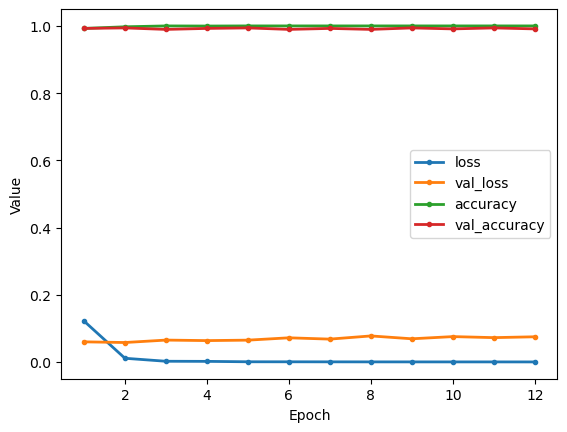

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
3955,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3645,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4162,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,0.002653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,267,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,309,057 (134.69 MB)

 Trainable params: 35,309,057 (134.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 26s 637ms/step - accuracy: 0.4531 - loss: 0.6932

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4375 - loss: 0.6934 

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4566 - loss: 0.6933

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.4674 - loss: 0.6932

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4727 - loss: 0.6931

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.4790 - loss: 0.6930

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4830 - loss: 0.6929

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4861 - loss: 0.6927

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.4892 - loss: 0.6926

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.4913 - loss: 0.6925

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4933 - loss: 0.6923

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.4954 - loss: 0.6921

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4971 - loss: 0.6920

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4986 - loss: 0.6918

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4994 - loss: 0.6916

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4998 - loss: 0.6914

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4999 - loss: 0.6912

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4999 - loss: 0.6910

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5004 - loss: 0.6908

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5013 - loss: 0.6905

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5027 - loss: 0.6903

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5043 - loss: 0.6900

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5064 - loss: 0.6897

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5087 - loss: 0.6893

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5111 - loss: 0.6889

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5138 - loss: 0.6885

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5167 - loss: 0.6881

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5197 - loss: 0.6876

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5229 - loss: 0.6871

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5264 - loss: 0.6866

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5300 - loss: 0.6859

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5338 - loss: 0.6853

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5376 - loss: 0.6846

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5415 - loss: 0.6839

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5454 - loss: 0.6831

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5493 - loss: 0.6822

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5532 - loss: 0.6813

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5571 - loss: 0.6803

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5609 - loss: 0.6793

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5648 - loss: 0.6782

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5686 - loss: 0.6771

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5724 - loss: 0.6759

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5761 - loss: 0.6748

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.5796 - loss: 0.6736 - val_accuracy: 0.9970 - val_loss: 0.3923


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 1.0000 - loss: 0.3981

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.3971 

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.3897

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.3822

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.3758

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.3703

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9997 - loss: 0.3661

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9990 - loss: 0.3621

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9985 - loss: 0.3576

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9982 - loss: 0.3534

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9980 - loss: 0.3492

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9978 - loss: 0.3449

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9977 - loss: 0.3405

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9975 - loss: 0.3365

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9973 - loss: 0.3324

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9972 - loss: 0.3284

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9971 - loss: 0.3244

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9969 - loss: 0.3205

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9968 - loss: 0.3166

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9968 - loss: 0.3126

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9967 - loss: 0.3088

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9966 - loss: 0.3050

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9966 - loss: 0.3012

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9965 - loss: 0.2974

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9964 - loss: 0.2938

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9964 - loss: 0.2902

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9963 - loss: 0.2866

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9962 - loss: 0.2831

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9962 - loss: 0.2797

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9961 - loss: 0.2764

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9960 - loss: 0.2731

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9960 - loss: 0.2699

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9959 - loss: 0.2668

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9959 - loss: 0.2637

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9958 - loss: 0.2607

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9958 - loss: 0.2578

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9957 - loss: 0.2549

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9957 - loss: 0.2521

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9957 - loss: 0.2494

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9956 - loss: 0.2468

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9956 - loss: 0.2443

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9956 - loss: 0.2418

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9956 - loss: 0.2394

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9955 - loss: 0.2372 - val_accuracy: 0.9941 - val_loss: 0.0338


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 1.0000 - loss: 0.0053

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0052

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0056

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0057

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0059

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0059

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0059

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0059

 9/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0059

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0058

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0058

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0058

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0058

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0058

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9999 - loss: 0.0059

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9997 - loss: 0.0060

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9997 - loss: 0.0061

18/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9996 - loss: 0.0061

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9995 - loss: 0.0062

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9995 - loss: 0.0062

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9994 - loss: 0.0062

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9994 - loss: 0.0062

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9993 - loss: 0.0062

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9993 - loss: 0.0062

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9993 - loss: 0.0062

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9993 - loss: 0.0062

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9993 - loss: 0.0062

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0061

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0061

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0061

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0061

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0060

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9992 - loss: 0.0060

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9992 - loss: 0.0061

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9991 - loss: 0.0061

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9991 - loss: 0.0061

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9991 - loss: 0.0061

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9991 - loss: 0.0061

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9991 - loss: 0.0061

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9990 - loss: 0.0061

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9990 - loss: 0.0063

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9990 - loss: 0.0064

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9990 - loss: 0.0065

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9990 - loss: 0.0066 - val_accuracy: 0.9970 - val_loss: 0.0283


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 1.0000 - loss: 0.0023

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 0.0023

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 0.0023

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0023

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0024

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0025

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0025

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0025

 9/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0025

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0025

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0024

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0024

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0024

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0024

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0023

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0023

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0023

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0023

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0023

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0022

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0022

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0022

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0022

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0021

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0021

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0023

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0024

28/43 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9999 - loss: 0.0025

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9999 - loss: 0.0027

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9999 - loss: 0.0027

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 0.0028

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 0.0029

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9999 - loss: 0.0030

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9999 - loss: 0.0030

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0031

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9998 - loss: 0.0031

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0032

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0032

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0033

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9998 - loss: 0.0033

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9998 - loss: 0.0033

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0034

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0034

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 0.9941 - val_loss: 0.0276


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 1.0000 - loss: 0.0011

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0010

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 9.6921e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 9.3254e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 9.0921e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.9082e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 8.7810e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 8.7666e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 8.8252e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 8.8633e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 8.8887e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 8.8856e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 8.8626e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 8.8674e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.8739e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 8.8612e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 8.8379e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 8.8129e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.7843e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 8.7488e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.7115e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.6760e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.6448e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 8.6109e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.5820e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.5557e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0010    

28/43 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0012

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9999 - loss: 0.0013

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9999 - loss: 0.0014

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9999 - loss: 0.0015

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9999 - loss: 0.0016

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9999 - loss: 0.0017

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0018

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9999 - loss: 0.0019

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0019

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9999 - loss: 0.0020

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0020

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0021

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0021

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9998 - loss: 0.0022

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9998 - loss: 0.0022

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 0.0022

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9941 - val_loss: 0.0305


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.1671e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.0869e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 6.0777e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 7.8405e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 8.6997e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 9.0510e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 9.1610e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 9.1919e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 9.1399e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 9.0721e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.9869e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.8834e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.7817e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.6799e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.5817e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.4895e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.4030e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.3204e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.2329e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.1544e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.0806e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.0110e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.9504e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.8880e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.8259e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.7803e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.8322e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 9.7736e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0011    

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0011

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0012

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0013

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0013

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9999 - loss: 0.0014

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9999 - loss: 0.0014

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9999 - loss: 0.0014

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9999 - loss: 0.0015

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0015

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9998 - loss: 0.0015

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9998 - loss: 0.0016

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9998 - loss: 0.0016

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9998 - loss: 0.0016

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9998 - loss: 0.0016

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9941 - val_loss: 0.0351


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 1.0000 - loss: 0.0017

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0013

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0011

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0010

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 9.3018e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 8.7278e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 8.2801e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 7.9519e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.6546e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.3865e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.1500e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.9337e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.7645e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.6880e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.6138e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.5393e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.4715e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.4027e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.3351e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.2678e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.2018e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.1390e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.0780e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.0190e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.9626e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.9091e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.8571e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.8073e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.7586e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 5.7114e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.6648e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 5.6199e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.5759e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 5.5326e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.4923e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.7738e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 6.0301e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 6.2657e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 6.4811e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 6.6781e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9999 - loss: 6.8591e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9999 - loss: 7.0255e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9999 - loss: 7.1827e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9999 - loss: 7.3328e-04 - val_accuracy: 0.9941 - val_loss: 0.0347


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 1.0000 - loss: 0.0037

 2/43 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 1.0000 - loss: 0.0029 

 3/43 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 1.0000 - loss: 0.0024

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 0.0021

 5/43 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 0.0019

 6/43 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0018

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0016

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0015

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0014

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0014

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0013

12/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0012

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0012

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0011

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0011

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0011

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0010

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0010

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 9.7807e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 9.5259e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.2894e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 9.0699e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.8635e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.6740e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4973e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.3306e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.1767e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.0324e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.8959e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.7659e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.6413e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.5229e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.4120e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.3057e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.2035e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.1051e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.0108e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.9210e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.8346e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.7525e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.6733e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.5971e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.5242e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 6.4547e-04 - val_accuracy: 0.9941 - val_loss: 0.0303


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 1.0000 - loss: 1.1675e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.4772e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.5397e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.6303e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.6924e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.7375e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.7717e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.7853e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.7938e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.7989e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.8022e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.8038e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.8022e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.7973e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.7915e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.7859e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.7809e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.7771e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.7751e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.9007e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.0093e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.1026e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.1836e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.2542e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.3154e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.3687e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.4158e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.4566e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.4927e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.5266e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.5581e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.5873e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6136e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6410e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6658e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.6882e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.7077e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.7255e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.7414e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.7562e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.7691e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.7809e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.7929e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 1.0000 - loss: 2.8044e-04 - val_accuracy: 0.9941 - val_loss: 0.0261


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 1.0000 - loss: 2.4477e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.2375e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1451e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0505e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.9646e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8949e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8398e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.7988e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.7704e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.7418e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.7154e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.6954e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.6774e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.6585e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.6398e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6376e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.6324e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.6266e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.6194e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.6107e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.6020e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.5949e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.5883e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5825e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5778e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5732e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5940e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6140e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6330e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6500e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6666e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6809e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.6932e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7036e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7125e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7204e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7282e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7349e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7403e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.7451e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.7491e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7522e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7552e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.7580e-04 - val_accuracy: 0.9941 - val_loss: 0.0306


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 1.0000 - loss: 1.6735e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.5076e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.6344e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.6202e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.5874e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6494e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.6723e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.6836e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.6802e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6725e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6616e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6466e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.6305e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6125e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.5956e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.5795e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.5652e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.5523e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5391e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5329e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5263e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.5193e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5127e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5054e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.4980e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.5006e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.5015e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.5016e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.5042e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.5058e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.5065e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.5071e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.5067e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.5058e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.5042e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.5021e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.4993e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.4963e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.4931e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.4897e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.4865e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.4829e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4795e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4762e-04 - val_accuracy: 0.9941 - val_loss: 0.0297



[Train Accuracy: 100.00% - Test Accuracy: 99.64%]


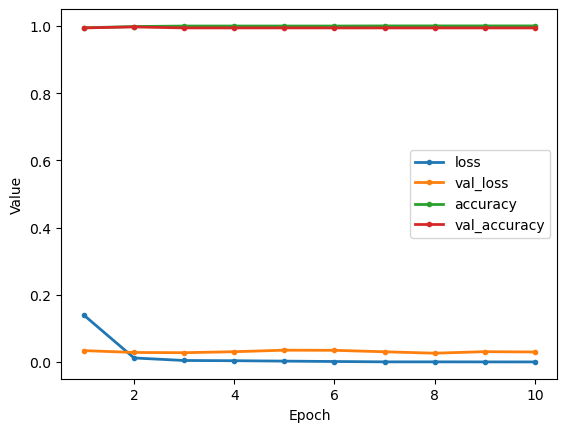

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

 6/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [25]:
report.save()

Report saved as Output/Reports/CO-like/report_8ZXZCTY4.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################